In [11]:
import sys
import os
from dotenv import load_dotenv
from database.db_utils import build_engine
from sqlalchemy.orm import sessionmaker, declarative_base, aliased
from database.model import CountryData
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


In [4]:
load_dotenv()

work_dir = os.getenv('WORK_DIR')

sys.path.append(work_dir)

print('Workdir: ', work_dir)

Workdir:  /home/carol/Escritorio/workshop-03


In [5]:
engine = build_engine()
Session = sessionmaker(bind=engine)
session = Session()


Successfully connected to the database workshop3!


In [6]:
base = declarative_base()
table = aliased(CountryData)
query = session.query(table).statement
df = pd.read_sql(query, engine)

In [7]:
df.shape

(235, 19)

In [9]:
df.head()

,id,Healthy_life_expectancy,Social_support,Economy,Generosity,Year,Freedom_to_make_life_choices,Perceptions_of_corruption,Region_Central_and_Eastern_Europe,Region_Eastern_Asia,Region_Latin_America_and_Caribbean,Region_Middle_East_and_Northern_Africa,Region_North_America,Region_Southeastern_Asia,Region_Southern_Asia,Region_Sub_Saharan_Africa,Region_Western_Europe,score,score_predicted
0,68,0.61766,1.07772,0.93929,0.07822,2015,0.28579,0.17383,False,False,False,True,False,False,False,False,False,5.605,5.069420
1,596,0.39100,0.95000,0.30800,0.22000,2018,0.45200,0.14600,False,False,False,False,False,False,False,True,False,4.350,4.281363
2,588,0.36500,1.28100,0.87400,0.05100,2018,0.51900,0.06400,False,False,False,False,False,False,False,True,False,4.441,4.355090
3,544,0.42400,0.81000,0.65200,0.21600,2018,0.33400,0.11300,False,False,False,False,False,False,True,False,False,5.472,4.573898
4,646,0.82500,1.31000,1.50300,0.26200,2019,0.59800,0.18200,False,False,False,True,False,False,False,False,False,6.825,6.897595


In [12]:
mse = mean_squared_error(df['score'], df['score_predicted'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(df['score'], df['score_predicted'])
r2 = r2_score(df['score'], df['score_predicted'])

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

MSE: 0.188065615239514
RMSE: 0.43366532630533655
MAE: 0.33215879893899297
R²: 0.8493898132889055


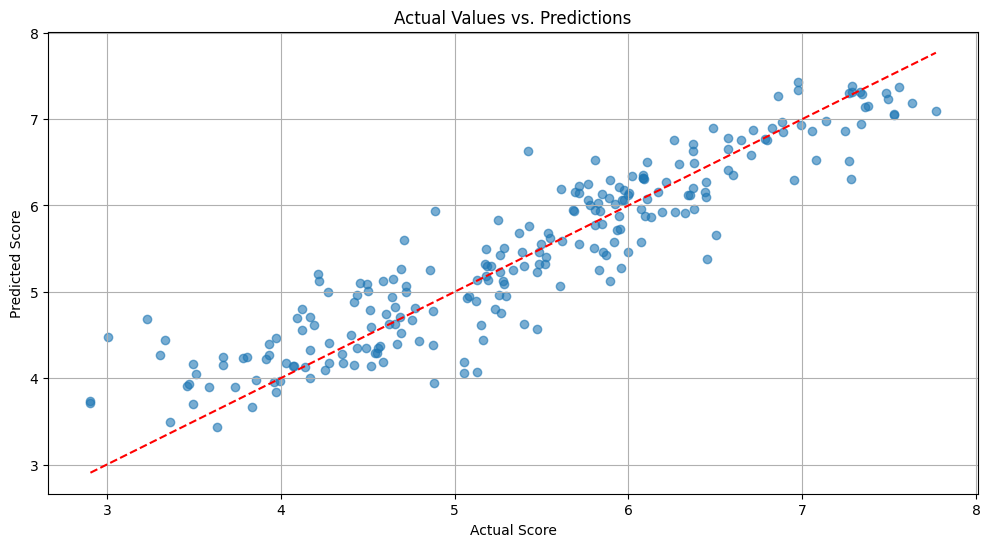

In [15]:
plt.figure(figsize=(12, 6))
plt.scatter(df['score'], df['score_predicted'], alpha=0.6)
plt.plot([df['score'].min(), df['score'].max()], 
         [df['score'].min(), df['score'].max()], 
         color='red', linestyle='--')  # reference line
plt.title('Actual Values vs. Predictions')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.grid()
plt.show()

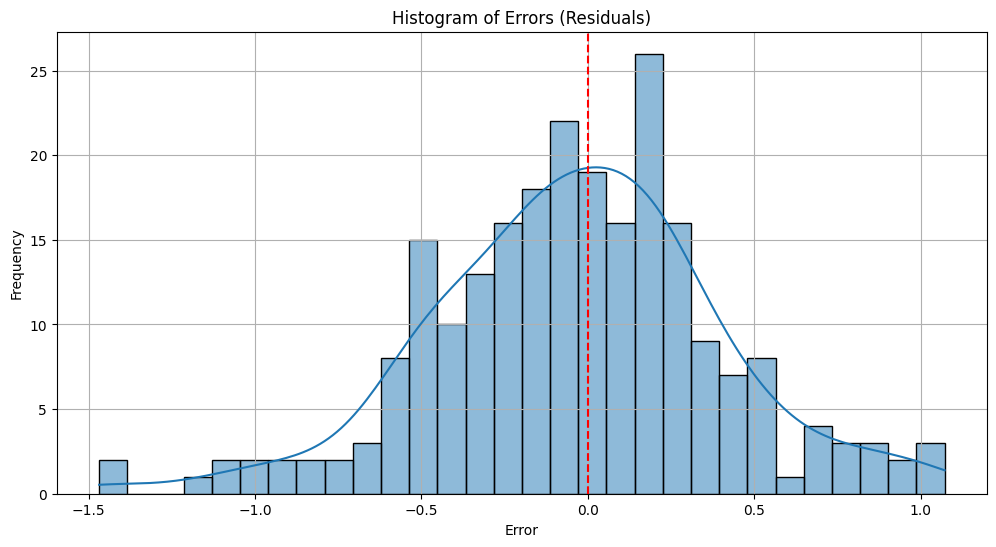

In [19]:
residuals = df['score'] - df['score_predicted']

plt.figure(figsize=(12, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Errors (Residuals)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--') 
plt.grid()
plt.show()

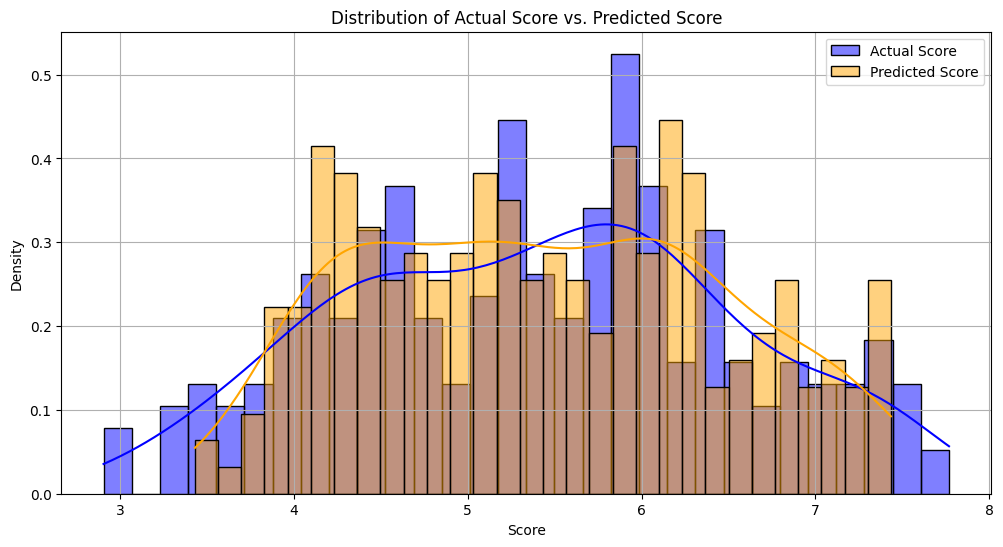

In [25]:
plt.figure(figsize=(12, 6))
sns.histplot(df['score'], bins=30, color='blue', label='Actual Score', kde=True, stat='density', alpha=0.5)
sns.histplot(df['score_predicted'], bins=30, color='orange', label='Predicted Score', kde=True, stat='density', alpha=0.5)
plt.title('Distribution of Actual Score vs. Predicted Score')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

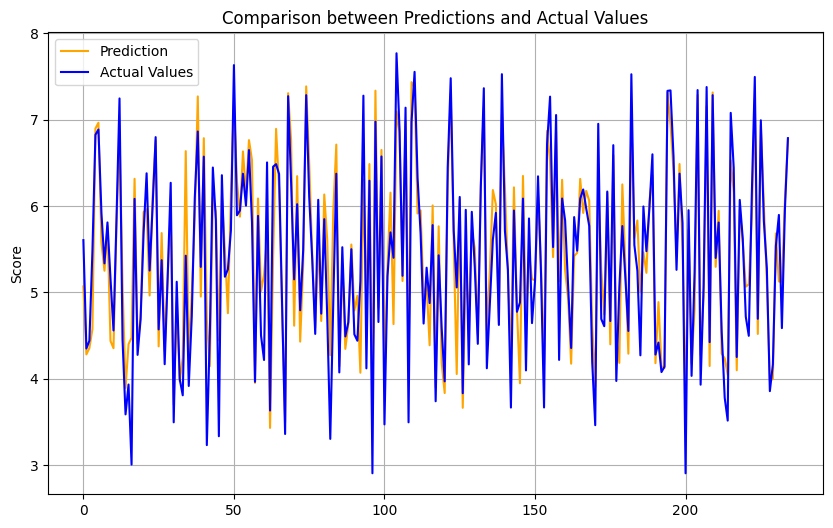

In [26]:
y_pred = df['score_predicted']
y_true = df['score']

plt.figure(figsize=(10, 6))

plt.plot(y_pred, label='Prediction', color='orange')
plt.plot(y_true.values, label='Actual Values', color='blue')
plt.ylabel('Score')
plt.title('Comparison between Predictions and Actual Values')
plt.legend()
plt.grid()
plt.show()

In [36]:
best_pipeline = joblib.load('../models/best_model_Random_forest.pkl')

In [53]:
df = pd.read_csv('../data/data_clean.csv')

df = pd.get_dummies(df, columns=['Region'], drop_first=True)

df.drop(columns=['Country', 'Happiness_Rank'], axis=1, inplace=True)

X = df.drop(columns=['Score']) 
y = df['Score'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [54]:
X.columns

Index(['Healthy_life_expectancy', 'Social_support', 'Economy', 'Generosity',
       'Year', 'Freedom_to_make_life_choices', 'Perceptions_of_corruption',
       'Region_Central and Eastern Europe', 'Region_Eastern Asia',
       'Region_Latin America and Caribbean',
       'Region_Middle East and Northern Africa', 'Region_North America',
       'Region_Southeastern Asia', 'Region_Southern Asia',
       'Region_Sub-Saharan Africa', 'Region_Western Europe'],
      dtype='object')

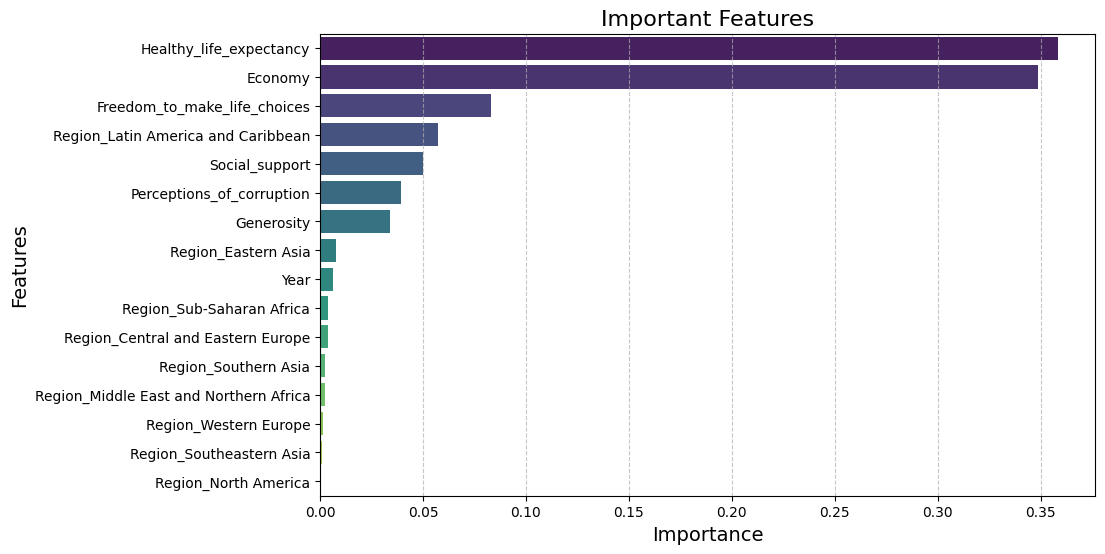

In [58]:
num_cols = X.columns

importances = best_pipeline.feature_importances_
feature_names = [col for col in num_cols if col != 'Score'] 

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', dodge=False, hue='Feature', legend=False)
plt.title('Important Features', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



In [59]:
for feature, importance in zip(importance_df['Feature'], importance_df['Importance']):
    print(f"{feature}: {importance:.4f}")

Healthy_life_expectancy: 0.3584
Economy: 0.3486
Freedom_to_make_life_choices: 0.0832
Region_Latin America and Caribbean: 0.0572
Social_support: 0.0502
Perceptions_of_corruption: 0.0394
Generosity: 0.0339
Region_Eastern Asia: 0.0076
Year: 0.0065
Region_Sub-Saharan Africa: 0.0040
Region_Central and Eastern Europe: 0.0038
Region_Southern Asia: 0.0025
Region_Middle East and Northern Africa: 0.0024
Region_Western Europe: 0.0012
Region_Southeastern Asia: 0.0009
Region_North America: 0.0001
